## Data analysis of marketing data

Author: Maksim Krivolapov maksim.krivolapov@roivenue.com

Goal:

How to use it:

In [4]:
import pandas as pd
import sys
import json
import ipywidgets as widgets
encoding = sys.getdefaultencoding()
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"

from scipy.optimize import least_squares
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from datetime import datetime

import cufflinks as cf
cf.go_offline()

## TDOO list:
* plot function
* select function
* fitting function
* cross-fold testing
* fitting curve 

### Data format
*

### API description:
*

In [5]:
# Data type description for dataset columns

DateTimeID = ['periodStartDate']

usecols = [
    "adCampaign", "platformCode", "channelCode", "marketingInvestment",
    "impressions", "clicks", "visits", "conversions", "deliveries",
    "netRevenue", "grossProfit", "adGroup", "periodStartDate"
          ]

dtype = {
    'adCampaign': str,
    'platformCode': str,
    'channelCode': str,
    'marketingInvestment': float
}

dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [6]:
df = pd.read_csv('MarketingReport_3.csv',
                 sep="\t",
                 infer_datetime_format=True,
                 usecols=usecols,
                 dtype=dtype,
                 parse_dates=DateTimeID)
df.head(10)

,platformCode,channelCode,adCampaign,marketingInvestment,impressions,clicks,visits,conversions,deliveries,netRevenue,grossProfit,adGroup,periodStartDate
0,unpaid,direct,NaN,0.00,0,0,0,1,0,0.0,0.00,(not set),2019-01-01
1,AdWords,googleadsdsother,NaN,0.00,0,0,2,0,0,0.0,0.00,(not set),2019-01-01
2,unpaid,organic,NaN,0.00,0,0,0,1,1,1997.8,348.94,(not set),2019-01-01
3,Compari,compari,-,116.77,0,65,0,0,0,0.0,0.00,NaN,2019-01-01
4,AdWords,googleadsdsother,(not set),0.00,0,0,0,0,0,0.0,0.00,(not set),2019-01-01
5,unpaid,notset,all,0.00,0,0,2,0,0,0.0,0.00,all,2019-01-01
6,unpaid,direct,all,0.00,0,0,136,0,0,0.0,0.00,all,2019-01-01
7,unpaid,organic,all,0.00,0,0,219,0,0,0.0,0.00,all,2019-01-01
8,AdWords,googleadsdsother,Brand,7.45,52,42,49,0,0,0.0,0.00,Kytary,2019-01-01
9,AdWords,googleadsdsother,BW (Product) - Dechy a příslušenství,0.00,1,0,0,0,0,0.0,0.00,Akai EWI USB,2019-01-01


In [7]:
df.shape

(552145, 13)

In [8]:
df["periodStartDate"].head()

0   2019-01-01
1   2019-01-01
2   2019-01-01
3   2019-01-01
4   2019-01-01
Name: periodStartDate, dtype: datetime64[ns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552145 entries, 0 to 552144
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   platformCode         552145 non-null  object        
 1   channelCode          552145 non-null  object        
 2   adCampaign           539847 non-null  object        
 3   marketingInvestment  552145 non-null  float64       
 4   impressions          552145 non-null  int64         
 5   clicks               552145 non-null  int64         
 6   visits               552145 non-null  int64         
 7   conversions          552145 non-null  int64         
 8   deliveries           552145 non-null  int64         
 9   netRevenue           552145 non-null  float64       
 10  grossProfit          552145 non-null  float64       
 11  adGroup              448297 non-null  object        
 12  periodStartDate      552145 non-null  datetime64[ns]
dtypes: datetime64[

In [10]:
df.describe()

,marketingInvestment,impressions,clicks,visits,conversions,deliveries,netRevenue,grossProfit
count,552145.000000,5.521450e+05,552145.000000,552145.000000,552145.000000,552145.000000,5.521450e+05,552145.000000
mean,34.793451,5.705076e+02,8.752681,17.005816,0.438760,0.403472,1.247430e+03,327.842636
std,338.041268,1.163864e+04,50.157213,162.964540,5.846953,5.523954,1.642993e+04,4622.899785
min,-2220.820000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-4.766428e+04,-79762.730000
25%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
50%,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000
75%,5.180000,3.000000e+01,2.000000,3.000000,0.000000,0.000000,0.000000e+00,0.000000
max,40859.550000,3.735211e+06,3965.000000,9014.000000,408.000000,397.000000,1.247776e+06,588690.900000


In [11]:
#df.isnull().sum()

In [12]:
df['platformCode'].unique()

array(['unpaid', 'AdWords', 'Compari', 'FacebookBusinessAdsManager',
       'Adminis', 'Yottly', 'Not tracked', 'Organic', 'Idealo', 'Ceneo',
       'Internal', 'Adform', 'CjAffiliate', 'Arukereso', 'Olcsobbat',
       'HeurekaCz', 'Sklik', 'OneSignal', 'ZboziCz', 'RtbHouse', 'Samba',
       'Radio', 'Outdoor', 'POS', 'Promo_materialy', 'Print', 'Pricespy',
       'Bing', 'notset', 'HeurekaSk'], dtype=object)

In [13]:
df['platformCode'].unique().size

30

In [14]:
df['channelCode'].unique().size

62

In [15]:
df['conversions'].unique().size

237

In [16]:
#df['adCampaign'].head(30)
compaigns_all = df.adCampaign.unique().tolist()

print(compaigns_all, '\n Data type:', type(compaigns_all), '\n Size of the list:', len(compaigns_all))

[nan, '-', '(not set)', 'all', 'Brand', 'BW (Product) - Dechy a příslušenství', 'BW (Product) - Dechy a příslušenství (non-brand)', 'BW (Product) - Klavesy a prislusenstvi (non-brand)', 'BW (Product) - Kytary a prislusenstvi', 'BW (Product) - Kytary a prislusenstvi (non-brand)', 'BW (Product) - Zvuk a prislusenstvi', 'BW (Product) - Zvuk a prislusenstvi (non-brand)', 'DSA - produkty', 'facebook.com', 'Klávesy - obecná', 'Kytary - obecná', 'l.facebook.com', 'lm.facebook.com', 'm.facebook.com', 'NotifikaceAktivaceBonusu', 'NotifikaceExpiraceBonusu', 'Obsah - Remarketing - Akce', 'PotvrzeniObjednavky', 'PotvrzeniSouhlasu', 'promoter_posts_engagement_mobile', 'Promoter-A-Engagement (RO) DESKTOP', 'Promoter-A-Engagement (RO) MOBILE', 'Promoter-A-Link Clicks (RO)', 'yot_email_anarchiero', 'yot_email_pfro', 'yot_popup_welcome_optin', 'accesorii-portabile-audio-video', 'BW (Product) - Bici a prislusenstvi (non-brand)', 'BW (Product) - Smyčce a příslušenství', 'Dechy - obecná', 'Klávesy - značk

limit_output extension: Maximum message size of 10000 exceeded with 65495 characters

In [17]:
len(compaigns_all)

2580

In [18]:
platform_code = df.platformCode.unique().tolist()
platform_code.sort()
print(platform_code, '\n Data type:', type(platform_code), '\n Size of the list:', len(platform_code))

['AdWords', 'Adform', 'Adminis', 'Arukereso', 'Bing', 'Ceneo', 'CjAffiliate', 'Compari', 'FacebookBusinessAdsManager', 'HeurekaCz', 'HeurekaSk', 'Idealo', 'Internal', 'Not tracked', 'Olcsobbat', 'OneSignal', 'Organic', 'Outdoor', 'POS', 'Pricespy', 'Print', 'Promo_materialy', 'Radio', 'RtbHouse', 'Samba', 'Sklik', 'Yottly', 'ZboziCz', 'notset', 'unpaid'] 
 Data type: <class 'list'> 
 Size of the list: 30


In [19]:
channel_code = df.channelCode.unique().tolist()
channel_code.sort()
print(channel_code, '\n Data type:', type(channel_code), '\n Size of the list:', len(channel_code))

['Adform', 'Affiliate', 'Ceneo', 'CjAffiliate', 'Direct', 'HeurekaCz', 'HeurekaSk', 'Internal', 'RtbHouse', 'ZboziCz', 'adwordsdsa', 'adwordsother', 'adwordspla', 'adwordsremarketing', 'adwordssmartshopping', 'adwordssmartshoppingcampaign', 'arukereso', 'bing', 'compari', 'direct', 'email', 'facebookother', 'facebookremarketing', 'facebookremarketingcross', 'firmycz', 'googleadsapr', 'googleadsbra', 'googleadsbrand', 'googleadsbrandsearch', 'googleadsdsa', 'googleadsdsother', 'googleadsobecna', 'googleadsobsah', 'googleadsother', 'googleadspla', 'googleadsppcbee', 'googleadsremarketing', 'googleadsroiminer', 'googleadssbrand', 'googleadssearch', 'googleadssee-think', 'googleadssmartdispaly', 'googleadsznacky', 'idealo', 'internal', 'internalreferral', 'notset', 'olcsobbat', 'openx', 'organic', 'pricespy', 'promoterengagement', 'promoterlinkclicks', 'promoterother', 'pushchannel', 'referral', 'sklikbrandsearch', 'sklikobsah', 'sklikpla', 'sklikremarketing', 'skliksearch', 'youtube'] 
 D

In [20]:
#df[df['platformCode'] == platform_code[2]]

In [21]:
df['periodStartDate'] = pd.to_datetime(df['periodStartDate']) # TODO  format = ''

In [22]:
#df['periodStartDate'] = df['periodStartDate'].dt.strftime('%U')
df

,platformCode,channelCode,adCampaign,marketingInvestment,impressions,clicks,visits,conversions,deliveries,netRevenue,grossProfit,adGroup,periodStartDate
0,unpaid,direct,NaN,0.00,0,0,0,1,0,0.0,0.00,(not set),2019-01-01
1,AdWords,googleadsdsother,NaN,0.00,0,0,2,0,0,0.0,0.00,(not set),2019-01-01
2,unpaid,organic,NaN,0.00,0,0,0,1,1,1997.8,348.94,(not set),2019-01-01
3,Compari,compari,-,116.77,0,65,0,0,0,0.0,0.00,NaN,2019-01-01
4,AdWords,googleadsdsother,(not set),0.00,0,0,0,0,0,0.0,0.00,(not set),2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
552140,Yottly,email,Email,80.00,0,0,0,0,0,0.0,0.00,-,2019-01-27
552141,Yottly,email,Email,80.00,0,0,0,0,0,0.0,0.00,-,2019-01-28
552142,Yottly,email,Email,80.00,0,0,0,0,0,0.0,0.00,-,2019-01-29
552143,Yottly,email,Email,80.00,0,0,0,0,0,0.0,0.00,-,2019-01-30


In [23]:
#df = df[df['platformCode'] == 'AdWords']

In [24]:
total_rev= df.groupby(['platformCode','periodStartDate'], as_index=False)[['netRevenue']].sum()

In [25]:
group_data = df.groupby(['periodStartDate']).agg({
    'netRevenue': 'sum',
    'marketingInvestment': 'sum',
    'visits': 'sum',
    'conversions': 'sum',
    'deliveries': 'sum',
    'impressions': 'sum',
    'clicks': 'sum',
    'grossProfit': 'sum'
})
group_data.head(10)

,netRevenue,marketingInvestment,visits,conversions,deliveries,impressions,clicks,grossProfit
periodStartDate,,,,,,,,
2019-01-01,476686.51,51595.28,26966,242,211,931859,18285,112505.45
2019-01-02,1413016.65,58245.27,34471,538,472,1036382,19863,317327.24
2019-01-03,1535926.14,55986.39,32919,474,432,950725,18842,357048.50
2019-01-04,2798999.31,47078.09,34258,882,805,855437,16578,645743.22
2019-01-05,1311820.45,38706.44,28298,535,481,714328,13891,381255.45
2019-01-06,1342289.89,41716.50,29817,491,444,872735,14978,317879.60
2019-01-07,2329503.02,48965.93,32318,834,762,884253,15192,580929.76
2019-01-08,2383081.16,41170.65,31040,813,735,726208,13607,576296.42
2019-01-09,1794998.16,40650.54,30157,777,710,696830,13566,492768.98


In [26]:
group_data['ROI'] = (group_data['grossProfit'] /
                     group_data['marketingInvestment']) * 100
group_data['CPI'] = (group_data['marketingInvestment'] /
                     group_data['deliveries']) * 100
group_data.head(10)

,netRevenue,marketingInvestment,visits,conversions,deliveries,impressions,clicks,grossProfit,ROI,CPI
periodStartDate,,,,,,,,,,
2019-01-01,476686.51,51595.28,26966,242,211,931859,18285,112505.45,218.053764,24452.739336
2019-01-02,1413016.65,58245.27,34471,538,472,1036382,19863,317327.24,544.812034,12340.099576
2019-01-03,1535926.14,55986.39,32919,474,432,950725,18842,357048.50,637.741601,12959.812500
2019-01-04,2798999.31,47078.09,34258,882,805,855437,16578,645743.22,1371.642775,5848.209938
2019-01-05,1311820.45,38706.44,28298,535,481,714328,13891,381255.45,984.992291,8047.076923
2019-01-06,1342289.89,41716.50,29817,491,444,872735,14978,317879.60,761.999688,9395.608108
2019-01-07,2329503.02,48965.93,32318,834,762,884253,15192,580929.76,1186.395847,6425.975066
2019-01-08,2383081.16,41170.65,31040,813,735,726208,13607,576296.42,1399.774888,5601.448980
2019-01-09,1794998.16,40650.54,30157,777,710,696830,13566,492768.98,1212.207710,5725.428169


In [27]:
group_data_w = group_data.resample('W-MON').agg('sum')
group_data_w['ROI'] = (group_data_w['grossProfit'] /
                       group_data_w['marketingInvestment']) * 100
group_data_w['CPI'] = (group_data_w['marketingInvestment'] /
                       group_data_w['deliveries']) * 100
group_data_w.head(10)

,netRevenue,marketingInvestment,visits,conversions,deliveries,impressions,clicks,grossProfit,ROI,CPI
periodStartDate,,,,,,,,,,
2019-01-07,11208241.97,342293.90,219047,3996,3607,6245719,117629,2712689.22,792.502940,9489.711672
2019-01-14,13963614.56,285424.40,205010,5088,4646,4565499,92685,3505869.08,1228.300412,6143.443823
2019-01-21,12517757.48,285409.64,192277,4514,4151,4151416,91313,3369107.41,1180.446256,6875.683932
2019-01-28,10522310.42,276260.13,190413,4147,3771,4514798,90839,3401136.96,1231.135655,7325.911695
2019-02-04,11680063.41,287621.79,195092,4122,3771,4714077,98707,2976843.82,1034.985500,7627.202068
2019-02-11,11453533.70,279320.47,189740,4267,3906,4521773,100546,2900958.24,1038.577029,7151.061700
2019-02-18,11364935.01,276900.51,183246,4256,3902,4091739,93670,3020571.29,1090.850750,7096.373911
2019-02-25,12071808.42,304766.38,185504,4316,3967,4187327,89340,3013307.63,988.727047,7682.540459
2019-03-04,11448563.17,309007.90,177447,4073,3716,4730412,91342,2932615.03,949.042089,8315.605490


In [28]:
group_data_w['ROI'].sort_values().head(10)

periodStartDate
2020-01-06    414.351912
2019-12-30    457.378548
2019-11-25    495.964688
2019-11-18    596.761589
2019-12-02    602.727736
2019-11-11    667.266509
2019-10-28    688.067781
2019-11-04    747.899889
2019-01-07    792.502940
2019-04-22    853.559889
Name: ROI, dtype: float64

#### Shapiro-Wilk Test (distribution's normality test) 

In [29]:
from scipy.stats import shapiro
stat, p = shapiro(group_data_w['ROI'])
print(f'stat = {stat}, Pr = {p} \n')

stat = 0.9378690123558044, Pr = 0.00835456419736147 



{'whiskers': [<matplotlib.lines.Line2D at 0xd29cb20>,
 'caps': [<matplotlib.lines.Line2D at 0xd2b1220>,
 'boxes': [<matplotlib.lines.Line2D at 0xd29c7c0>],
 'medians': [<matplotlib.lines.Line2D at 0xd2b18e0>],
 'fliers': [<matplotlib.lines.Line2D at 0xd2b1c40>],
 'means': []}

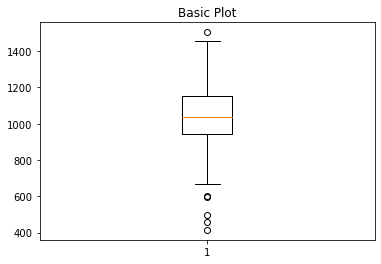

In [30]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(group_data_w['ROI'])

In [31]:
group_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   netRevenue           365 non-null    float64
 1   marketingInvestment  365 non-null    float64
 2   visits               365 non-null    int64  
 3   conversions          365 non-null    int64  
 4   deliveries           365 non-null    int64  
 5   impressions          365 non-null    int64  
 6   clicks               365 non-null    int64  
 7   grossProfit          365 non-null    float64
 8   ROI                  365 non-null    float64
 9   CPI                  365 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 31.4 KB


In [32]:
group_data.head()

,netRevenue,marketingInvestment,visits,conversions,deliveries,impressions,clicks,grossProfit,ROI,CPI
periodStartDate,,,,,,,,,,
2019-01-01,476686.51,51595.28,26966,242,211,931859,18285,112505.45,218.053764,24452.739336
2019-01-02,1413016.65,58245.27,34471,538,472,1036382,19863,317327.24,544.812034,12340.099576
2019-01-03,1535926.14,55986.39,32919,474,432,950725,18842,357048.50,637.741601,12959.812500
2019-01-04,2798999.31,47078.09,34258,882,805,855437,16578,645743.22,1371.642775,5848.209938
2019-01-05,1311820.45,38706.44,28298,535,481,714328,13891,381255.45,984.992291,8047.076923


In [33]:
group_data_filtered = group_data.rolling(window=10).mean()
fig1 = group_data_filtered.plot()
fig1.update_layout(title_text="Figure discription", title_font=dict(size=20))
fig1.update_layout(uniformtext_minsize=16, uniformtext_mode='hide')
fig1.show()

In [34]:
fig3 = group_data_w.plot()
fig3.update_layout(title_text="Figure discription", title_font=dict(size=20))
fig3.update_layout(uniformtext_minsize=16, uniformtext_mode='hide')
fig3.show()

In [35]:
fig4 = group_data.plot(group_data,
                       x=group_data.index,
                       y=['grossProfit', 'marketingInvestment', 'ROI', 'CPI'])
fig4.update_layout(title_text="Figure discription", title_font=dict(size=20))
fig4.update_layout(uniformtext_minsize=16, uniformtext_mode='hide')
fig4.show()

In [36]:
fig5 = group_data_w.plot(
    group_data_w,
    x=group_data_w.index,
    y=['grossProfit', 'marketingInvestment', 'netRevenue'])
fig5.update_layout(title_text="Weekly grouped data", title_font=dict(size=20))
fig5.update_layout(uniformtext_minsize=16, uniformtext_mode='hide')
fig5.show()

In [37]:
fig6 = group_data_w.plot(group_data_w, x = group_data_w.index, y = ['ROI'])
fig6.update_layout(title_text="Weekly grouped data", title_font=dict(size=20))
fig6.update_layout(uniformtext_minsize=16, uniformtext_mode='hide')
fig6.show()

In [38]:
group_data_sort = group_data.sort_values(by=['marketingInvestment'],
                                         ascending=False)
fig7 = group_data_sort.plot.scatter(x='marketingInvestment', y='grossProfit')
fig7.update_layout(title_text="Figure discription", title_font=dict(size=20))
fig7.update_layout(uniformtext_minsize=16, uniformtext_mode='hide')
fig7.show()

In [39]:
group_data_sort = group_data.sort_values(
    by=['marketingInvestment'], ascending=False)
fig8 = group_data_sort.plot.scatter(x='marketingInvestment', y='netRevenue')
fig8.update_layout(title_text="Figure discription", title_font=dict(size=20))
fig8.update_layout(uniformtext_minsize=16, uniformtext_mode='hide')
fig8.show()

In [40]:
total_rev

,platformCode,periodStartDate,netRevenue
0,AdWords,2019-01-01,106439.59
1,AdWords,2019-01-02,226968.06
2,AdWords,2019-01-03,250949.17
3,AdWords,2019-01-04,272137.54
4,AdWords,2019-01-05,186231.73
...,...,...,...
8921,unpaid,2019-12-27,663615.97
8922,unpaid,2019-12-28,359828.83
8923,unpaid,2019-12-29,546314.31
8924,unpaid,2019-12-30,581631.28


In [41]:
market_invest = df.groupby(['platformCode', 'periodStartDate'],
                           as_index=False)[['marketingInvestment']].sum()
market_invest

,platformCode,periodStartDate,marketingInvestment
0,AdWords,2019-01-01,30144.39
1,AdWords,2019-01-02,36342.63
2,AdWords,2019-01-03,37037.12
3,AdWords,2019-01-04,28560.95
4,AdWords,2019-01-05,21761.36
...,...,...,...
8921,unpaid,2019-12-27,0.00
8922,unpaid,2019-12-28,0.00
8923,unpaid,2019-12-29,0.00
8924,unpaid,2019-12-30,0.00


In [42]:
market_invest.groupby(['platformCode'], 
                      as_index=True)[['marketingInvestment']].sum().sort_values(by=['marketingInvestment'], 
                                                                                 ascending  = False)

,marketingInvestment
platformCode,
AdWords,10602969.80
Adform,1279186.81
FacebookBusinessAdsManager,1191521.50
Radio,1080737.55
Sklik,1070710.59
Arukereso,717533.07
HeurekaCz,644856.11
Yottly,611901.93
HeurekaSk,521201.12


In [43]:
import plotly.express as px
import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"


In [44]:
fig8 = group_data.plot(x=group_data.index, y='netRevenue', kind="bar")
fig8.update_layout(title_text="Total net revenue", title_font=dict(size=20))
fig8.update_layout(uniformtext_minsize=16, uniformtext_mode='hide')
fig8.show()

In [45]:
fig9 = group_data.plot(x=group_data.index, y='marketingInvestment', kind="bar")
fig9.update_layout(title_text="Total marketing investment",
                   title_font=dict(size=20))
fig9.update_layout(uniformtext_minsize=16, uniformtext_mode='hide')
fig9.show()

## Main settings
* Data preparation 

In [46]:
# Data source
data_source = widgets.Dropdown(
    options = ['platform','compaign','channel'],
    value='platform',
    description='Data source:',
    disabled=False,
)
display(data_source)

Dropdown(description='Data source:', options=('platform', 'compaign', 'channel'), value='platform')

In [47]:
data_source.value

'platform'

In [48]:
# platform code
if '__All__' not in platform_code: platform_code.insert(0, '__All__')
platform = widgets.Dropdown(
    options = platform_code,
    value=platform_code[1],
    description='Platform:',
    disabled=False,
)
display(platform)

Dropdown(description='Platform:', index=1, options=('__All__', 'AdWords', 'Adform', 'Adminis', 'Arukereso', 'B…

In [49]:
platform.value

'AdWords'

In [50]:
### Data preprocessing
if platform.value == 'all':
    df_selected = df
else:
    df_selected = df[df['platformCode'] == platform.value]

In [51]:
granularity = widgets.Dropdown(
    options=['day', 'week', 'month'],
    value='week',
    description='Granularity:',
    disabled=False,
)
display(granularity)

Dropdown(description='Granularity:', index=1, options=('day', 'week', 'month'), value='week')

In [52]:
granularity.value

'week'

In [53]:
#df_selected.head(5)

In [54]:
compaigns = df_selected.adCampaign.unique().tolist()
len(compaigns)

1019

In [55]:
if '__All__' not in compaigns: compaigns.insert(0, '__All__')
compaigns_list = widgets.Dropdown(
    options=compaigns,
    value='__All__',
    description='Compaigns code:',
    disabled=False,
)
display(compaigns_list)

Dropdown(description='Compaigns code:', options=('__All__', nan, '(not set)', 'Brand', 'BW (Product) - Dechy a…

In [56]:
compaigns_list.value

'__All__'

## Curve fitting  

In [57]:
df_selected.head(10)


,platformCode,channelCode,adCampaign,marketingInvestment,impressions,clicks,visits,conversions,deliveries,netRevenue,grossProfit,adGroup,periodStartDate
1,AdWords,googleadsdsother,NaN,0.00,0,0,2,0,0,0.0,0.0,(not set),2019-01-01
4,AdWords,googleadsdsother,(not set),0.00,0,0,0,0,0,0.0,0.0,(not set),2019-01-01
8,AdWords,googleadsdsother,Brand,7.45,52,42,49,0,0,0.0,0.0,Kytary,2019-01-01
9,AdWords,googleadsdsother,BW (Product) - Dechy a příslušenství,0.00,1,0,0,0,0,0.0,0.0,Akai EWI USB,2019-01-01
10,AdWords,googleadsdsother,BW (Product) - Dechy a příslušenství,2.76,1,2,1,0,0,0.0,0.0,Buffet Crampon 100 Series Tenor,2019-01-01
11,AdWords,googleadsdsother,BW (Product) - Dechy a příslušenství,0.00,1,0,0,0,0,0.0,0.0,Vandoren Alto Sax V5 A27,2019-01-01
12,AdWords,googleadsdsother,BW (Product) - Dechy a příslušenství,1.32,1,1,1,0,0,0.0,0.0,Yamaha YAS-280,2019-01-01
13,AdWords,googleadsdsother,BW (Product) - Dechy a příslušenství,0.00,3,0,0,0,0,0.0,0.0,Yamaha YRF 21B,2019-01-01
14,AdWords,googleadsdsother,BW (Product) - Dechy a příslušenství (non-brand),0.00,1,0,0,0,0,0.0,0.0,Akai EWI USB,2019-01-01
15,AdWords,googleadsdsother,BW (Product) - Dechy a příslušenství (non-brand),0.00,1,0,0,0,0,0.0,0.0,Best Brass Warm Up,2019-01-01


In [58]:
df_selected['channelCode'].unique()

array(['googleadsdsother', 'googleadsremarketing', 'youtube', 'notset',
       'googleadspla', 'googleadsppcbee', 'googleadsother',
       'googleadsobecna', 'googleadsznacky', 'googleadsdsa',
       'googleadsroiminer', 'googleadssbrand', 'googleadssee-think',
       'googleadssmartdispaly', 'googleadssearch', 'googleadsbrandsearch',
       'googleadsobsah', 'adwordsother', 'adwordsremarketing',
       'adwordssmartshoppingcampaign', 'adwordsdsa', 'adwordspla',
       'adwordssmartshopping', 'googleadsbra', 'googleadsapr',
       'googleadsbrand'], dtype=object)

In [59]:
#df_selected['adCampaign'].unique()

In [60]:
#df_selected.head()

In [61]:
df_selected_agg = df_selected.groupby(['periodStartDate']).agg({'netRevenue':'sum',
                                                 'marketingInvestment':'sum',
                                                 'visits':'sum',
                                                 'conversions':'sum',
                                                 'deliveries':'sum',
                                                 'impressions':'sum',
                                                 'clicks':'sum',
                                                 'netRevenue': 'sum',
                                                 'grossProfit':'sum'})

df_selected_agg.head(5)

,netRevenue,marketingInvestment,visits,conversions,deliveries,impressions,clicks,grossProfit
periodStartDate,,,,,,,,
2019-01-01,106439.59,30144.39,9907,65,49,599737,10109,23731.45
2019-01-02,226968.06,36342.63,12727,138,119,711540,12703,60771.04
2019-01-03,250949.17,37037.12,12885,110,94,712806,12808,54783.53
2019-01-04,272137.54,28560.95,10940,103,88,621273,10765,59464.18
2019-01-05,186231.73,21761.36,9240,81,65,574806,8857,29828.59


In [62]:
if granularity.value == 'week':
    df_selected_agg = df_selected_agg.resample('W-MON').agg('sum')
if granularity.value == 'month':
    df_selected_agg = df_selected_agg.resample('M', convention='end').agg('sum')
else:
    pass

df_selected_agg['ROI'] = (df_selected_agg['grossProfit']/df_selected_agg['marketingInvestment'])*100
df_selected_agg['CPI'] = (df_selected_agg['marketingInvestment']/df_selected_agg['deliveries'])*100
df_selected_agg.head(5)

,netRevenue,marketingInvestment,visits,conversions,deliveries,impressions,clicks,grossProfit,ROI,CPI
periodStartDate,,,,,,,,,,
2019-01-07,1414407.17,206649.38,77268,673,568,4676824,76244,306517.07,148.327118,36381.933099
2019-01-14,1606098.21,157245.86,65550,682,595,3673334,63984,359034.75,228.326997,26427.875630
2019-01-21,1261219.78,157910.99,62951,573,510,3382189,60937,292942.80,185.511344,30962.939216
2019-01-28,1308808.49,168121.91,67613,528,455,3768166,66019,311074.43,185.029084,36949.870330
2019-02-04,1316704.64,169790.31,68016,532,457,3868527,67063,320151.70,188.557109,37153.240700


In [63]:
df_selected_agg.head(5)

,netRevenue,marketingInvestment,visits,conversions,deliveries,impressions,clicks,grossProfit,ROI,CPI
periodStartDate,,,,,,,,,,
2019-01-07,1414407.17,206649.38,77268,673,568,4676824,76244,306517.07,148.327118,36381.933099
2019-01-14,1606098.21,157245.86,65550,682,595,3673334,63984,359034.75,228.326997,26427.875630
2019-01-21,1261219.78,157910.99,62951,573,510,3382189,60937,292942.80,185.511344,30962.939216
2019-01-28,1308808.49,168121.91,67613,528,455,3768166,66019,311074.43,185.029084,36949.870330
2019-02-04,1316704.64,169790.31,68016,532,457,3868527,67063,320151.70,188.557109,37153.240700


In [64]:
df_selected_agg['CPI'].isna().sum()

0

In [65]:
fig_agg = df_selected_agg.plot.scatter(x = 'marketingInvestment', y = 'netRevenue')
fig_agg.update_layout( title_text = f"Revenue to investment on {platform.value} platform with {granularity.value} granularity", 
                       title_font = dict(size=20))

fig_agg.update_layout(uniformtext_minsize = 16, uniformtext_mode = 'hide')
fig_agg.show()

In [66]:

fig11 = px.histogram(df_selected_agg, x = 'marketingInvestment', y = 'netRevenue', nbins = 50)
fig11.show()

In [67]:
fig_agg_2 = df_selected_agg.plot(df_selected_agg, x = df_selected_agg.index, y = ['ROI'])
fig_agg_2.update_layout( title_text = f"ROI on {platform.value} platform with {granularity.value} granularity", 
                         title_font=dict(size=20))

fig_agg_2.update_layout(uniformtext_minsize=16, uniformtext_mode='hide')
fig_agg_2.show()

In [68]:
fig_agg_10 = df_selected_agg.plot(
    df_selected_agg, x=df_selected_agg.index, y=['marketingInvestment'])
fig_agg_10.update_layout(title_text=f"Marketing investment on {platform.value} platform with {granularity.value} granularity",
                         title_font=dict(size=20))

fig_agg_10.update_layout(uniformtext_minsize=16, uniformtext_mode='hide')
fig_agg_10.show()

In [69]:
fig_agg_4 = df_selected_agg.plot(df_selected_agg, x=df_selected_agg.index, y=np.convolve(
    df_selected_agg['ROI'], [0.5, 0.5, 0.5, 0.5], 'same'))
fig_agg_4.update_layout(
    title_text=f"ROI filtered by rolling window on {platform.value} platform with {granularity.value} granularity", title_font=dict(size=20))
fig_agg_4.update_layout(uniformtext_minsize=16, uniformtext_mode='hide')
fig_agg_4.show()

In [70]:
fig_agg_4 = df_selected_agg.plot(df_selected_agg,
                                 x=df_selected_agg.index,
                                 y=df_selected_agg['ROI'].rolling(4).median())
fig_agg_4.update_layout(
    title_text=
    f"ROI filtered by median filter on {platform.value} platform with {granularity.value} granularity",
    title_font=dict(size=20))
fig_agg_4.update_layout(uniformtext_minsize=16, uniformtext_mode='hide')
fig_agg_4.show()

In [71]:
fig_agg_4 = df_selected_agg.plot(df_selected_agg,
                                 x=df_selected_agg.index,
                                 y=df_selected_agg['ROI'].ewm(
                                     span=20, adjust=False).mean())
fig_agg_4.update_layout(
    title_text=
    f"ROI filtered by exponential moving average on {platform.value} platform with {granularity.value} granularity",
    title_font=dict(size=20))
fig_agg_4.update_layout(uniformtext_minsize=16, uniformtext_mode='hide')
fig_agg_4.show()

In [72]:
fig_agg_3 = df_selected_agg.plot(df_selected_agg,
                                 x=df_selected_agg.index,
                                 y=['CPI'])
fig_agg_3.update_layout(
    title_text=
    f"CPI on {platform.value} platform with {granularity.value} granularity",
    title_font=dict(size=20))
fig_agg_3.update_layout(uniformtext_minsize=16, uniformtext_mode='hide')
fig_agg_3.show()

## Optimization problem 

In [73]:
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

In [74]:
def function(x, a, b, c):
    return a*(1 - np.exp(-(x/b))) + c
    # return a * np.log(b * x) # ??? return negative value

#df_selected_agg.sort_values(by=['marketingInvestment'], inplace = True)
t_train = df_selected_agg['marketingInvestment']
y_train = df_selected_agg['netRevenue']

x0 = np.ones(3)

In [75]:
type(df_selected_agg['marketingInvestment'])

pandas.core.series.Series

In [76]:
#plt.scatter(t_train, y_train)

In [77]:
df_selected_agg.head()

,netRevenue,marketingInvestment,visits,conversions,deliveries,impressions,clicks,grossProfit,ROI,CPI
periodStartDate,,,,,,,,,,
2019-01-07,1414407.17,206649.38,77268,673,568,4676824,76244,306517.07,148.327118,36381.933099
2019-01-14,1606098.21,157245.86,65550,682,595,3673334,63984,359034.75,228.326997,26427.875630
2019-01-21,1261219.78,157910.99,62951,573,510,3382189,60937,292942.80,185.511344,30962.939216
2019-01-28,1308808.49,168121.91,67613,528,455,3768166,66019,311074.43,185.029084,36949.870330
2019-02-04,1316704.64,169790.31,68016,532,457,3868527,67063,320151.70,188.557109,37153.240700


In [78]:
type(y_train)

pandas.core.series.Series

In [79]:
max(t_train)

524496.5900000001

In [80]:
# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = function(t_train, *parameterTuple)
    return np.sum((y_train - val) ** 2.0)

In [81]:
# function for search initial value for regression parameters
from scipy.optimize import differential_evolution
import warnings
def generate_Initial_Parameters():
    # min and max used for bounds
    maxX = max(t_train)
    minX = min(t_train)
    maxY = max(y_train)
    minY = min(y_train)
    maxXY = max(maxX, maxY)

    parameterBounds = []
    parameterBounds.append([-maxXY, maxXY]) # seach bounds for a
    parameterBounds.append([-maxXY, maxXY]) # seach bounds for b
    parameterBounds.append([-maxXY, maxXY]) # seach bounds for c

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x


In [82]:
geneticParameters = generate_Initial_Parameters()

In [83]:
min(t_train)

33549.379999999976

In [84]:
max(t_train)

524496.5900000001

In [85]:
geneticParameters

array([5166779.71      ,  330782.94985193, -672210.15843526])

In [86]:
#res_lsq = least_squares(function, x0, args=(t_train, y_train))
def line(x, a, b):
    return a * x + b

#popt, pcov = curve_fit(function, t_train, y_train, geneticParameters)

popt, pcov = curve_fit(line, t_train, y_train)
popt

import plotly.graph_objects as go
fig = go.Figure()
# Add traces
fig.add_trace(
    go.Scatter(x=np.linspace(min(t_train), max(t_train), num=100) ,
               y=line(np.linspace(min(t_train), max(t_train), num=100), *popt),
               mode='lines',
               name='Polynomial regression (projection)'))
fig.add_trace(
    go.Scatter(x=t_train,
               y=y_train,
               mode='markers',
               name='Initial dataset'))
fig.update_layout(
    title_text=
    f"Revenue to investment on {platform.value} platform with {granularity.value} granularity",
    title_font=dict(size=20))
fig.show()

In [87]:
popt

array([ 9.68053423e+00, -3.54288204e+05])

In [88]:
pcov

array([[ 1.72339137e-01, -3.44774846e+04],
       [-3.44774846e+04,  8.34956641e+09]])

In [89]:
max(t_train)

524496.5900000001

In [90]:
perr = np.sqrt(np.diag(pcov))
perr

array([4.15137492e-01, 9.13759619e+04])

In [91]:
#plt.hist(df_selected_agg["CPI"], bins = 25)

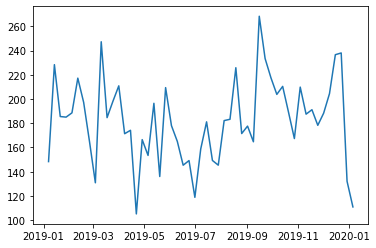

In [92]:
plt.plot((df_selected_agg['ROI']))

In [93]:
corr = np.corrcoef(df_selected_agg['marketingInvestment'],df_selected_agg['netRevenue'])

In [94]:
corr

array([[1.        , 0.95616551],
       [0.95616551, 1.        ]])

In [95]:
corr[0,1]

0.9561655109281895

In [96]:
import scipy
scipy.stats.spearmanr(df_selected_agg['marketingInvestment'],df_selected_agg['netRevenue'])

SpearmanrResult(correlation=0.6264312207708433, pvalue=5.238559201995959e-07)

In [97]:
group_data_channel = df.groupby(['periodStartDate','channelCode']).agg({'netRevenue':'sum',
                                                 'marketingInvestment':'sum',
                                                 'visits':'sum',
                                                 'conversions':'sum',
                                                 'deliveries':'sum',
                                                 'impressions':'sum',
                                                 'clicks':'sum',
                                                 'grossProfit':'sum'})
group_data_channel.head(10)

netRevenue  marketingInvestment  visits  \
periodStartDate channelCode                                            
2019-01-01      Adform             0.00                 0.00       6   
                Affiliate          0.00                 0.00      25   
                Ceneo          11819.74              3162.69     332   
                CjAffiliate        0.00                 0.00      10   
                Direct        182266.24                 0.00    6070   
                HeurekaCz        446.28                77.42      19   
                HeurekaSk          0.00               884.72     114   
                Internal        8387.12                 0.00      33   
                ZboziCz         3995.87               623.73     124   
                adwordsdsa         0.00                 0.00       0   

                             conversions  deliveries  impressions  clicks  \
periodStartDate channelCode                                                 
2019-01-01      Adform                 0           0          110       0   
                Affiliate              0           0            0       0   
                Ceneo                  6           6            0     892   
                CjAffiliate            0           0            0       0   
                Direct                84          77            0       0   
                HeurekaCz              1           1            0       0   
                HeurekaSk              0           0            0     119   
                Internal               1           1            0       0   
                ZboziCz                3           3         3404     113   
                adwordsdsa             0           0            0       0   

                             grossProfit  
periodStartDate channelCode               
2019-01-01      Adform              0.00  
                Affiliate           0.00  
                Ceneo            3010.52  
                CjAffiliate         0.00  
                Direct          41432.35  
                HeurekaCz         257.59  
                HeurekaSk           0.00  
                Internal         1177.54  
                ZboziCz           836.15  
                adwordsdsa          0.00

In [98]:
group_data_channel.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20813 entries, (Timestamp('2019-01-01 00:00:00'), 'Adform') to (Timestamp('2019-12-31 00:00:00'), 'youtube')
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   netRevenue           20813 non-null  float64
 1   marketingInvestment  20813 non-null  float64
 2   visits               20813 non-null  int64  
 3   conversions          20813 non-null  int64  
 4   deliveries           20813 non-null  int64  
 5   impressions          20813 non-null  int64  
 6   clicks               20813 non-null  int64  
 7   grossProfit          20813 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 1.3+ MB


1. Select platform
2. Select channel or campaign
3. Plot data

In [99]:
for i in df_selected['adCampaign'].unique():
    print(str(i))

nan
(not set)
Brand
BW (Product) - Dechy a příslušenství
BW (Product) - Dechy a příslušenství (non-brand)
BW (Product) - Klavesy a prislusenstvi (non-brand)
BW (Product) - Kytary a prislusenstvi
BW (Product) - Kytary a prislusenstvi (non-brand)
BW (Product) - Zvuk a prislusenstvi
BW (Product) - Zvuk a prislusenstvi (non-brand)
DSA - produkty
Klávesy - obecná
Kytary - obecná
Obsah - Remarketing - Akce
BW (Product) - Bici a prislusenstvi (non-brand)
BW (Product) - Smyčce a příslušenství
Dechy - obecná
Klávesy - značky
Kytary - obecná + značky
Kytary - značky
Obsah - Remarketing - Dynamický
Smyčce - obecná
youtube.com
BW (Product) - Smyčce a příslušenství (non-brand)
Hudební nástroje
yot_email_anarchie2ro
microfon
doza-pentru-chitara
controler-midi
mixer-audio
yot_popup_welcome_kupon
m.facebook.com
microfon-calculator
PotvrzeniSouhlasu
NotifikaceAktivaceBonusu
PotvrzeniObjednavky
boxa-portabila
accesorii-dj
l.facebook.com
instrument-de-tuner
coarde-chitara
NotifikaceExpiraceBonusu
suport-

limit_output extension: Maximum message size of 10000 exceeded with 21480 characters

In [100]:
for i in df_selected['channelCode'].unique():
    print(str(i))

googleadsdsother
googleadsremarketing
youtube
notset
googleadspla
googleadsppcbee
googleadsother
googleadsobecna
googleadsznacky
googleadsdsa
googleadsroiminer
googleadssbrand
googleadssee-think
googleadssmartdispaly
googleadssearch
googleadsbrandsearch
googleadsobsah
adwordsother
adwordsremarketing
adwordssmartshoppingcampaign
adwordsdsa
adwordspla
adwordssmartshopping
googleadsbra
googleadsapr
googleadsbrand


In [101]:
for i in df_selected['channelCode'].unique():
    group_data_channel = df[df['channelCode'] == i].groupby(['periodStartDate']).agg({'netRevenue':'sum',
                                                  'marketingInvestment':'sum',
                                                  'visits':'sum',
                                                  'conversions':'sum',
                                                  'deliveries':'sum',
                                                  'impressions':'sum',
                                                  'clicks':'sum',
                                                  'netRevenue': 'sum',
                                                  'grossProfit':'sum'})
    #print(group_data_channel['netRevenue'].head(1))

In [102]:
#chnl_lis = df['channelCode'].unique()
#chnl_lis

In [103]:
result = df_selected_agg['ROI'].describe()

In [104]:
type(result)

pandas.core.series.Series

In [105]:
result

count     53.000000
mean     182.287664
std       34.882474
min      105.156877
25%      164.690938
50%      183.246476
75%      204.413826
max      268.273041
Name: ROI, dtype: float64

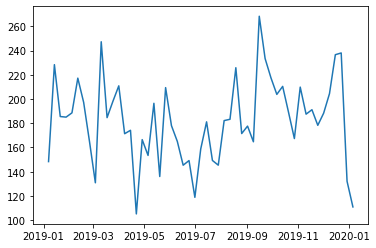

In [106]:
plt.plot(df_selected_agg['ROI'])

(array([2., 1., 0., 3., 2., 4., 1., 5., 6., 6., 5., 3., 6., 2., 1., 2., 2.,
        1., 0., 1.]),
 array([105.15687731, 113.31268548, 121.46849364, 129.62430181,
        137.78010998, 145.93591815, 154.09172631, 162.24753448,
        170.40334265, 178.55915082, 186.71495898, 194.87076715,
        203.02657532, 211.18238348, 219.33819165, 227.49399982,
        235.64980799, 243.80561615, 251.96142432, 260.11723249,
        268.27304066]),
 <BarContainer object of 20 artists>)

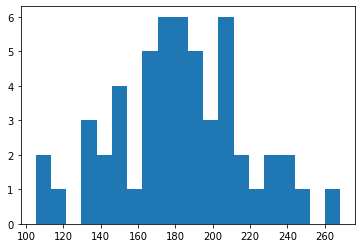

In [107]:
plt.hist(df_selected_agg['ROI'], bins = 20)

In [108]:
# skewness
df_selected_agg['ROI'].skew(axis = 0, skipna = True) 

0.02083889460730084

In [109]:
# Kurtosis
from scipy.stats import norm, kurtosis
kur = kurtosis(df_selected_agg['ROI'], fisher=True)
kur

-0.1412833783196552

In [110]:
# coefficient of variation
coeff_var = scipy.stats.variation(df_selected_agg['ROI'], axis=0)
coeff_var

0.18954561265004174

In [111]:
# 50% quantile
df_selected_agg['ROI'].quantile(.25)

164.69093821556453

In [112]:
df_selected_agg['ROI'].quantile(.75)

204.41382595416923

In [113]:
from scipy.stats import iqr
# inter quantile range
irq_result = iqr(df_selected_agg['ROI'], axis=0, keepdims=True)
irq_result

array([39.72288774])

In [114]:
type(irq_result)

numpy.ndarray

In [115]:
irq_result.item()

39.7228877386047

In [116]:
# Chi-squared test
chi_stat, chi_prob = scipy.stats.chisquare(df_selected_agg['ROI'])
chi_stat, chi_prob

(347.1048020990641, 3.0855788602128696e-45)

In [117]:
len(df_selected_agg['ROI'])

53

In [118]:
writer = pd.ExcelWriter('marketingInvestment_stat.xls')

df_selected_agg.to_excel(writer, sheet_name='Sheet1')

writer.save()

#df_selected_agg.to_excel("marketingInvestment.xlsx", index = False, header=True) 

In [119]:
with pd.ExcelWriter('output.xlsx', mode='a') as writer:  
    df_selected_agg.to_excel(writer, sheet_name='Sheet_name_3')

ValueError: Append mode is not supported with xlsxwriter!

In [ ]:
writer = pd.ExcelWriter('pandas_simple.xlsx', engine='xlsxwriter')

In [ ]:
import xlsxwriter